# Requirements

In [ ]:
'''
REQUIREMENTS TO RUN THIS NOTEBOOK:

1. Use deep learning model to run inference on all images in dataset.
    --> Can use trained YOLOv9 model in this Repository as is, and/or with additional training.
    --> Alternatively, other deep learning architectures can be used to train and validate new models.

2. Read output of deep learning predictions and re-format into dataframe containing the following columns:
    "osm_id_final"  -   a unique identifier for each building.
    "image_id"      -   a unique identifier for each image. Generally will be the same as the above, but since some facades
                        in the OSM dataset appear to contain more than one building when GSV images are extracted, the images
                        may be split and contain "_left", "_right", or other suffixes.
    "image_width"   -   the image width in pixels.
    "image_height:  -   the image height in pixels.
    "category_id"   -   0 for wall, 1 for glazing objects, 2 for garage doors.
    "score"         -   confidence score as used by YOLO model.
    "x_min"/"x_max" -   the x-min and x-max coordinate of detection bounding boxes, in absolute coordinates, within range 0.0 to image width.
    "y_min"/"y_max" -   the y-min and y-max coordinate of detection bounding boxes, in absolute coordinates, within range 0.0 to image height.
    "x_min_norm"/
    "x_max_norm"    -   the x-min and x-max coordinate in normalized coordinates, within range 0.0 to 1.0.
    "y_min_norm"/
    "y_max_norm"    -   the y-min and y-max coordinate in normalized coordinates, within range 0.0 to 1.0.
    "dataset"       -   which dataset the images come from: 'train', 'val', or 'inf_ds'

    --> The above dataframe should be exported to XLS/CSV format and saved as 'full_inference_results_pre_NMS.xlsx'
    --> The XLS/CSV file is then read into this notebook as the pd.DataFrame inf_pre_nms

Note there are sample images provided to visualize the post-scripts which are facsimile images taken by the authors.

'''

# Imports

In [ ]:
# Only required if using Google Colab and Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

# Load files

In [ ]:
MAIN_FOLDER = # ADD MAIN FOLDER PATH, e.g. '/content/drive/MyDrive/Project_Name/'
DATA_FOLDER = # ADD DATA FOLDER PATH, e.g. '/content/drive/MyDrive/Project_Name/data/'

In [4]:
inf_pre_nms = pd.read_excel(DATA_FOLDER+'full_inference_results_pre_NMS.xlsx')
inf_pre_nms

,osm_id_final,image_id,image_width,image_height,category_id,score,x_min_norm,y_min_norm,x_max_norm,y_max_norm,x_min,y_min,x_max,y_max,area,dataset
0,863796903_4,863796903_4_left,867,594,0,0.934388,0.004088,0.109253,0.999894,0.698347,3.544296,64.896282,866.908098,414.818118,302109.846732,val
1,863796903_4,863796903_4_left,867,594,1,0.918414,0.468974,0.156618,0.545802,0.301412,406.600848,93.031092,473.209944,179.038728,5728.890857,val
2,863796903_4,863796903_4_left,867,594,1,0.902896,0.149780,0.153991,0.260680,0.293610,129.858826,91.470357,226.009994,174.404043,7974.170693,val
3,863796903_4,863796903_4_left,867,594,1,0.897758,0.894700,0.161575,0.943454,0.298123,775.705030,95.975253,817.974488,177.085359,3428.480211,val
4,863796903_4,863796903_4_left,867,594,1,0.880096,0.893276,0.515027,0.943516,0.602003,774.470119,305.926276,818.028545,357.589544,2250.370712,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32722,864047705_6,864047705_6,373,401,1,0.903789,0.181230,0.159476,0.247664,0.249496,67.598902,63.949736,92.378560,100.048036,894.503553,inf_ds
32723,864047705_6,864047705_6,373,401,1,0.899852,0.188648,0.361882,0.254553,0.451601,70.365890,145.114482,94.948455,181.091801,884.414783,inf_ds
32724,864047705_6,864047705_6,373,401,1,0.883129,0.630071,0.156632,0.690499,0.248212,235.016446,62.809252,257.556164,99.533192,827.747294,inf_ds
32725,864047705_6,864047705_6,373,401,1,0.854981,0.792208,0.154026,0.856202,0.243828,295.493565,61.764446,319.363365,97.775008,859.564885,inf_ds


In [5]:
SAMPLE_IMG_DIR = DATA_FOLDER+'sample_images'
SAMPLE_IMG_LST = [os.path.basename(fname) for fname in sorted(glob(SAMPLE_IMG_DIR+"/*.jpg"))]

print(SAMPLE_IMG_LST)
print(len(SAMPLE_IMG_LST))

['1000254916_5.jpg', '1068899298_4.jpg', '1069198750_1.jpg', '1069198766_7.jpg', '108229725_3.jpg', '117467571_9.jpg', '197183074_3.jpg', '808449785_3_left.jpg', '844802792_3_left.jpg', '930961707_1_left.jpg']
10


# Define NMS and plot functions

In [6]:
# The several functions below run a second round of NMS to suppress detections between window and garage
# classes as well as suppress windows detections outside wall. The final function, process_nms_df, is the
# wrapper function to run all of the below functions on an input dataframe.

def get_boxes_labels_np(image_id, dataframe):
    """
    Function to format inputs for the subsequent NMS functions

    Arguments:
    image_                --  string; a unique image identifier
    dataframe             --  pd.DataFrame; the input dataframe consisting of all detections read from the output of
                              the deep learning model JSON or TXT files, concatenated into one dataframe.

    Returns:
    wall_boxes            --  list; a list [xmin, ymin, xmax, ymax] of detected wall objects (category_id == 0).
    box_np                --  np.array; an array of bounding boxes [xmin, ymin, xmax, ymax] for glazing and garage
                              door detections (category_ids == 1 or ==2, respectively).
    label_np              --  np.array; an array of labels identifying the category_id of each bounding box in box_np.
    prob_np               --  np.array; an array of confidence scores associated with each boudning box in box_np.
    """
    box_df = dataframe.loc[dataframe['image_id'] == image_id].reset_index()
    boxes = []
    wall_boxes = []
    labels = []
    probs = []


    for row in range(len(box_df.index)):
        label = int(box_df.at[row, 'category_id'])
        xmin = box_df.at[row, 'x_min']
        ymin = box_df.at[row, 'y_min']
        xmax = box_df.at[row, 'x_max']
        ymax = box_df.at[row, 'y_max']

        if label == 0:  # wall
            wall_boxes.append([xmin, ymin, xmax, ymax])
        else:
            labels.append(label)
            boxes.append([xmin, ymin, xmax, ymax])
            probs.append(box_df.at[row, 'score'])

    box_np = np.array(boxes)
    prob_np = np.array(probs)
    label_np = np.array(labels)
    label_np = np.expand_dims(label_np, axis=1)

    return wall_boxes, box_np, label_np, prob_np

def nms_conf(labels, boxes, probs, overlapThresh=0.5):
    """
    This NMS function is from https://pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/

    Function to run non-maximum suppression in between classes, i.e. to suppress
    overlapping glazing and garage objects, as the default output from YOLOv9 is to run
    NMS only within classes (e.g. one window overlapping another window).

    Arguments:
    boxes                 --  np.array; an array of bounding boxes [xmin, ymin, xmax, ymax] for glazing and garage
                              door detections (category_ids == 1 or ==2, respectively).
    labels                --  np.array; an array of labels identifying the category_id of each bounding box in boxes.
    probs                 --  np.array; an array of confidence scores associated with each boudning box in boxes.
    overlapThresh         --  the IoU threshold to apply to the NMS.

    Returns:
    boxes                 --  np.array; an array of post-NMS bounding boxes [xmin, ymin, xmax, ymax] for glazing and garage
                              door detections (category_ids == 1 or ==2, respectively), i.e. with the array without any
                              suppressed boxes.
    """
    if len(boxes) == 0:
        return [], [], []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(probs)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("float"), labels[pick].astype("int"), probs[pick].astype("float")


def bb_iou(boxA, boxB):
    """
    This IoU function is from https://gist.github.com/meyerjo/dd3533edc97c81258898f60d8978eddc

    Function to determine the (x, y)-coordinates of the intersection rectangle

    Arguments:
    boxA                  --  np.array; an array of one bounding box [xmin, ymin, xmax, ymax].
    boxB                  --  np.array; an array of a second bounding box [xmin, ymin, xmax, ymax].

    Returns:
    iou                   --  float; the value of the Intersection over Union (IoU) between boxA and boxB.
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxB[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute the intersection over union by taking the intersection area
    # and dividing it by the sum of prediction + ground-truth areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # Return the intersection over union value
    return iou


def suppress_window_outside_wall(wall_boxes, box_lst, label_np, threshold=0.001):
    """
    Our function to run calculate IoU between detected windows (in the box_lst) and the detected
    walls (in wall_boxes), using the above bb_iou function. If the IoU is above a specified threshold,
    the window detection is suppressed and a new_box_lst is returned to provide a list of window
    detections that are not outside detected walls.

    Arguments:
    wall_boxes            --  list; a list of bounding boxes [xmin, ymin, xmax, ymax] for wall objects (object_id == 0).
    box_lst               --  list; a list of bounding boxes [xmin, ymin, xmax, ymax] for glazing or garage door objects (object_id == 1 or ==2, respectively).
    label_np              --  np.array; an array of category_id labels associated with each boudning box in boxes.
    threshhold            --  the IoU threshold to apply to the NMS, set very low to permiet only small amounts of glazing/garages that
                              lie outside wall bounding boxes.

    Returns:
    new_box_lst           --  list; a list of post-NMS bounding boxes [xmin, ymin, xmax, ymax] for glazing and garage
                              door detections (category_ids == 1 or ==2, respectively), i.e. bounding boxes only
                              within the detected wall.
    new_label_lst         --  list; a list of labels associated with the bounding boxes in new_box_lst.
    """
    if len(wall_boxes) == 1:
        wall_boxes_np = np.array(wall_boxes)
        wall_boxes_np = wall_boxes_np[0]
        new_box_lst = []
        new_label_lst = []

        if len(box_lst) > 0:
            for i in range(len(box_lst)):
                label = int(label_np[i][0])
                test_box = box_lst[i]
                test_box = np.array(test_box)
                iou = bb_iou(wall_boxes_np, test_box)
                if iou > threshold:
                    test_box = list(test_box)
                    new_box_lst.append(test_box)
                    new_label_lst.append(label)

    return new_box_lst, new_label_lst


def process_nms_df(dataframe):
    """
    Our wrapper function to run all of the above NMS and IoU functions on an input dataframe

    Arguments:
    dataframe             --  pd.DataFrame; a dataframe of all detections from the deep learning model where two rounds of NMS shall be applied.

    Returns:
    new_dataframe         --  pd.DataFrame; the prcessed dataframe, after running the functions nms_conf and suppress_window_outside_wall
    """
    unique_image_ids = dataframe['image_id'].unique()
    results = []

    for image_id in unique_image_ids:
        image_height = dataframe.loc[dataframe['image_id'] == image_id, 'image_height'].values[0]
        image_width = dataframe.loc[dataframe['image_id'] == image_id, 'image_width'].values[0]
        dset = dataframe.loc[dataframe['image_id'] == image_id, 'dataset'].values[0]
        wall_boxes, boxes, labels, probs = get_boxes_labels_np(image_id, dataframe)

        for i in range(len(wall_boxes)):
          result = {
                  'image_id': image_id,
                  'category_id': 0,
                  'image_width': image_width,
                  'image_height': image_height,
                  'score':1.0,
                  'x_min_norm': wall_boxes[i][0] / image_width,
                  'y_min_norm': wall_boxes[i][1] / image_height,
                  'x_max_norm': wall_boxes[i][2] / image_width,
                  'y_max_norm': wall_boxes[i][3] / image_height,
                  'x_min': wall_boxes[i][0],
                  'y_min': wall_boxes[i][1],
                  'x_max': wall_boxes[i][2],
                  'y_max': wall_boxes[i][3],
                  'dataset': dset
          }
          results.append(result)

        if len(wall_boxes) > 0:
          # Apply non-maximum suppression
          filtered_boxes, filtered_labels, filtered_probs = nms_conf(labels, boxes, probs, overlapThresh=0.5)

        if len(wall_boxes) == 1:
          # Apply suppression of windows outside the wall
          # This NMS is not applied if two walls are detected in one image (which rarely happens)
          new_boxes, new_labels = suppress_window_outside_wall(wall_boxes, filtered_boxes, filtered_labels, threshold=0.001)

        for i in range(len(new_boxes)):
            result = {
                'image_id': image_id,
                'category_id': new_labels[i],
                'image_width': image_width,
                'image_height': image_height,
                'score': filtered_probs[i],
                'x_min_norm': new_boxes[i][0] / image_width,
                'y_min_norm': new_boxes[i][1] / image_height,
                'x_max_norm': new_boxes[i][2] / image_width,
                'y_max_norm': new_boxes[i][3] / image_height,
                'x_min': new_boxes[i][0],
                'y_min': new_boxes[i][1],
                'x_max': new_boxes[i][2],
                'y_max': new_boxes[i][3],
                'dataset': dset
            }
            results.append(result)

    new_dataframe = pd.DataFrame(results)
    new_dataframe['area'] = (new_dataframe['x_max'] - new_dataframe['x_min']) * (new_dataframe['y_max'] - new_dataframe['y_min'])
    return new_dataframe


def plot_results(image_id, df, img_dir, show_img=False, save_file=False, save_dir=None):
    """
    Our function to plot all detected boxes on validation results.

    Arguments:
    image_id              --  string; a unique image identifier.
    df                    --  pd.DataFrame; the dataframe containing all bounding boxes, to be used to plot detected boxes on image. Either pre-NMS
                              or post-NMS dataframes can be used with this plot function.
    img_dir               --  string; the path where images should be read from.
    show_img              --  boolean; whether images with plotted boudning boxes should be displayed using matplotlib.
    save_file             --  boolean; whether images with plotted bounding boxes should be saved.
    save_dir              --  string; the path where images should be saved.

    Returns:
    img_w_boxes           --  np.array; the np.array image of the input image with plotted bounding boxes.
    """

    box_df = df.loc[df['image_id']==image_id].reset_index()
    img_path = os.path.join(img_dir, image_id+'.jpg')
    img = cv2.imread(img_path)
    img_w_boxes = img.copy()

    for row in range(len(box_df.index)):
      label = int(box_df.at[row,'category_id'])
      xmin = int(box_df.at[row,'x_min'])
      ymin = int(box_df.at[row,'y_min'])
      xmax = int(box_df.at[row,'x_max'])
      ymax = int(box_df.at[row,'y_max'])

      if label == 0: #wall
        color = (255,0,0)
      elif label == 1: # window
        color = (0,255,0)
      elif label == 2: #garage
        color = (0,0,255)
      img_w_boxes = cv2.rectangle(img_w_boxes,(xmin, ymin), (xmax, ymax), color, 2)

    img_w_boxes = cv2.cvtColor(img_w_boxes, cv2.COLOR_BGR2RGB)

    if show_img==True:
      plt.axis("off")
      plt.imshow(img_w_boxes)

    if save_file==True:
      save_path = os.path.join(save_dir, image_id+'.jpg')
      cv2.imwrite(save_path, img_w_boxes)

    return img_w_boxes

# Run two NMS post-scripts

In [7]:
# Show value counts for category 0 (wall), 1 (glazing), and 2 (garage)
# before running additional rounds of NMS.

inf_pre_nms['category_id'].value_counts()

,count
category_id,
1,30434
0,1743
2,550


In [8]:
# Run process_nms_df function to (i) run NMS between glazing and garage classes,
# and (ii) suppress glazing/garage detections outside wall.

nms_inf_df = process_nms_df(inf_pre_nms)
nms_inf_df

,image_id,category_id,image_width,image_height,score,x_min_norm,y_min_norm,x_max_norm,y_max_norm,x_min,y_min,x_max,y_max,dataset,area
0,863796903_4_left,0,867,594,1.000000,0.004088,0.109253,0.999894,0.698347,3.544296,64.896282,866.908098,414.818118,val,302109.846732
1,863796903_4_left,1,867,594,0.918414,0.468974,0.156618,0.545802,0.301412,406.600848,93.031092,473.209944,179.038728,val,5728.890857
2,863796903_4_left,1,867,594,0.902896,0.149779,0.153991,0.260680,0.293610,129.858826,91.470357,226.009994,174.404043,val,7974.170693
3,863796903_4_left,1,867,594,0.897758,0.894700,0.161575,0.943454,0.298124,775.705030,95.975253,817.974488,177.085359,val,3428.480211
4,863796903_4_left,1,867,594,0.880096,0.893276,0.515027,0.943516,0.602003,774.470119,305.926276,818.028545,357.589544,val,2250.370712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32466,864047705_6,1,373,401,0.903789,0.181230,0.159476,0.247664,0.249496,67.598902,63.949736,92.378560,100.048036,inf_ds,894.503553
32467,864047705_6,1,373,401,0.899852,0.188648,0.361882,0.254553,0.451601,70.365890,145.114482,94.948455,181.091801,inf_ds,884.414783
32468,864047705_6,1,373,401,0.883129,0.630071,0.156632,0.690499,0.248212,235.016446,62.809252,257.556164,99.533192,inf_ds,827.747294
32469,864047705_6,1,373,401,0.854981,0.792208,0.154026,0.856202,0.243828,295.493565,61.764446,319.363365,97.775008,inf_ds,859.564885


In [9]:
# Now show value counts after running NMS.
# Only glazing and garage counts should be reduced.

nms_inf_df['category_id'].value_counts()

,count
category_id,
1,30204
0,1743
2,524


check id:  1000254916_5


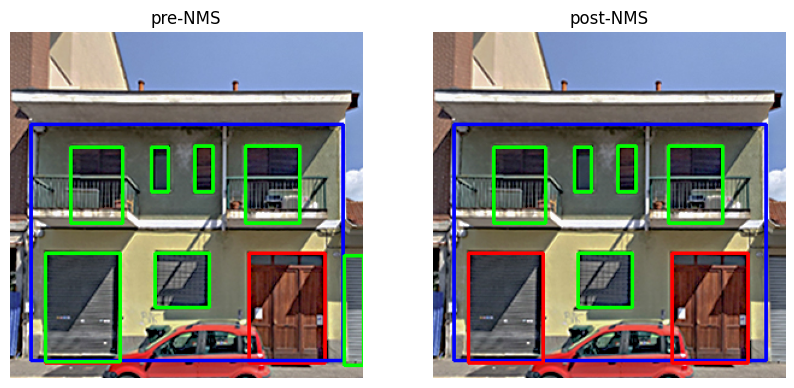

In [10]:
# Visualize one exmple with pre- and post-NMS.

check_id = SAMPLE_IMG_LST[0][:-4]
print('check id: ', check_id)
img_pre_nms = plot_results(check_id, inf_pre_nms, img_dir=SAMPLE_IMG_DIR)
img_nms = plot_results(check_id, nms_inf_df, img_dir=SAMPLE_IMG_DIR)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_pre_nms)
plt.axis('off')
plt.title('pre-NMS')
plt.subplot(1,2,2)
plt.imshow(img_nms)
plt.axis('off')
plt.title('post-NMS')
plt.show()

# Define functions to stratify detections into ground-level and above-ground

In [11]:
# Our function to stratify detections into lower windows, upper windows, lower wall, and upper wall
# by creating an imaginary 'border' that separates ground floor from all floors above.
# The thresholds defined help establish the border and help deal with spacing in between rows of
# windows under different conditions, as noted in the comments in the function definition.
# The 'cantina_ratio' affects small windows near the bottom of the image, which are actually part
# of the cellar/basement, and not part of the ground floor.
# Returns: a list of four dataframes, one each for lower windows, upper windows, lower wall, and upper wall.
def stratify_bldg(df, threshold=0.02, second_threshold=0.08, garage_threshold=0.05, cantina_ratio=0.3):
    # Initialize empty lists to be appended to
    first_row_boxes = []
    second_row_boxes = []
    wall_first_row_boxes = []
    wall_second_row_boxes = []

    for image_id, group in df.groupby('image_id'):
        # Initialize variables
        first_row = pd.DataFrame()
        second_row = pd.DataFrame()
        sorted_group = pd.DataFrame()
        highest_of_first_row = None
        lowest_of_second_row = None
        border = None

        # Check if there is a box with category_id == 2, i.e. garage
        garage_boxes = group[group['category_id'] == 2]
        if not garage_boxes.empty:
            garage_box = garage_boxes.loc[garage_boxes['y_min_norm'].idxmin()]
            border = garage_box['y_min_norm'] - garage_threshold
            window_boxes = group[group['category_id'] == 1]
            first_row = window_boxes[window_boxes['y_min_norm'] >= border]
            first_row = pd.concat([first_row, garage_boxes])
            second_row = pd.merge(window_boxes, first_row, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

            # Reset border to be halfway beween 'y_min' of first row and 'y_max' of second_row
            if not first_row.empty and not second_row.empty:
              highest_of_first_row = garage_boxes['y_min_norm'].min()
              lowest_of_second_row = second_row['y_max_norm'].max()
              border = (highest_of_first_row + lowest_of_second_row) / 2
              first_row = window_boxes[window_boxes['y_min_norm'] >= border]
              first_row = pd.concat([first_row, garage_boxes])
              second_row = pd.merge(window_boxes, first_row, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

            # Check top of garage and top of windows in second_row; if the difference is off by the second_threshold
            # then they are actually in the same row
            if abs(garage_boxes['y_min_norm'].min() - second_row['y_min_norm'].min()) <= second_threshold:
                first_row = pd.concat([garage_boxes, window_boxes])
                second_row = pd.DataFrame()
                border = None

            # Final if statement if garage is present --> if border cuts through garage then move border above garage using garage threshold
            if border is not None and border > garage_boxes['y_min_norm'].min() and border < garage_boxes['y_max_norm'].max():
              border = garage_boxes['y_min_norm'].min() - garage_threshold
              first_row = window_boxes[window_boxes['y_min_norm'] >= border]
              first_row = pd.concat([first_row, garage_boxes])
              second_row = pd.merge(window_boxes, first_row, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

            # This 'sorted_group' variable isn't doing anything in the garage if statement but
            # if abs(wall_y_max - lowest_window_y_max) <= second_threshold (much lower in code)
            # is invoked then it needs the sorted_group variable so add:
            sorted_group = pd.concat([first_row, second_row, garage_boxes])
            sorted_group = window_boxes.sort_values(by='y_min_norm', ascending=False)

        else:
            # If category_id == 2 is not present, proceed with the following logic
            window_boxes = group[group['category_id'] == 1]

            if window_boxes.empty:
                # In this case, there is no category_id == 1 present (sometimes only wall is detected, no windows)
                first_row = garage_boxes
                second_row = pd.DataFrame()
                wall_first_row = group[group['category_id'] == 0]
                wall_second_row = pd.DataFrame()
            elif len(window_boxes) == 1 or (window_boxes['y_min_norm'].max() - window_boxes['y_min_norm'].min() <= threshold):
                # Only one row of category_id == 1 or all y_min values are within the threshold
                first_row = window_boxes
                second_row = pd.DataFrame()
                wall_first_row = group[group['category_id'] == 0]
                wall_second_row = pd.DataFrame()
            else:
                # Sort by y_min in descending order
                sorted_group = window_boxes.sort_values(by='y_min_norm', ascending=False)
                # Identify the highest y_min of the lowest row
                highest_of_first_row = sorted_group.iloc[0]['y_min_norm']

                # Find the next distinct y_min value that is sufficiently different
                for i in range(1, len(sorted_group)):
                    if sorted_group.iloc[i]['y_min_norm'] < highest_of_first_row - threshold:  # Adjust the threshold as needed
                        lowest_of_second_row = sorted_group.iloc[i]['y_max_norm']
                        break
                else:
                    lowest_of_second_row = highest_of_first_row

                # Establish the border
                border = (highest_of_first_row + lowest_of_second_row) / 2

                # Classify the remaining boxes
                first_row = sorted_group[sorted_group['y_min_norm'] >= border]
                second_row = pd.merge(window_boxes, first_row, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

                # After classification, check if the average window size would fit in between bottom of first row
                # and bottom of wall. If so re-classify so that the first row is empty.
                all_windows = pd.concat([first_row, second_row])
                avg_height = (all_windows['y_max_norm'] - all_windows['y_min_norm']).mean()
                bottom_window = group.loc[group['category_id'] == 1, 'y_max_norm'].max()
                bottom_wall = group.loc[group['category_id'] == 0, 'y_max_norm'].max()

                # Check to see if there could be a first row of windows below the detected first row
                if avg_height < abs(bottom_wall - bottom_window) - second_threshold:
                  first_row = pd.DataFrame()
                  second_row = all_windows

                # If there are very small windows in first row, these do not define the border
                if not first_row.empty and not second_row.empty:
                  avg_height_first = (first_row['y_max_norm'] - first_row['y_min_norm']).mean()
                  avg_height_second = (second_row['y_max_norm'] - second_row['y_min_norm']).mean()

                  if avg_height_first/avg_height_second < cantina_ratio:
                    highest_of_second_row = second_row.loc[second_row['y_max_norm'] == lowest_of_second_row, 'y_min_norm'].values[0]
                    border = highest_of_second_row - second_threshold
                    first_row = sorted_group[sorted_group['y_min_norm'] >= border]
                    second_row = pd.merge(window_boxes, first_row, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
                    highest_of_first_row = first_row['y_min_norm'].min()
                    lowest_of_second_row = second_row['y_max_norm'].max()
                    # reset border once windows are sorted into new 'first' and 'second' groups
                    border = (highest_of_first_row + lowest_of_second_row) / 2

        # Check if first_row is empty but second_row is not empty
        if first_row.empty and not second_row.empty:
            # Calculate the average height of category_id == 1 items
            avg_height = (second_row['y_max_norm'] - second_row['y_min_norm']).mean()

            # get the y_max value from the group item that has 'category_id' == 0
            wall_y_max = group.loc[group['category_id'] == 0, 'y_max_norm'].max()
            lowest_window_y_max = second_row['y_max_norm'].max()

            # Calculate the top of the "imaginary" category_id == 1 item
            imaginary_top = wall_y_max - avg_height

            # Establish the border as the midpoint between the top of the "imaginary" item and the lowest y_max of the category_id == 1 items
            border = (imaginary_top + lowest_window_y_max) / 2

            # Check if the y_max of the category_id == 0 item is within the second threshold distance to the y_max of the category_id == 1 items
            if abs(wall_y_max - lowest_window_y_max) <= second_threshold:
                # Move all category_id == 1 items to the first row

                # find y_min of item whose y-max = lowest_window_y_max:
                lowest_window_y_min = group.loc[group['y_max_norm'] == lowest_window_y_max, 'y_min_norm'].min()
                border = lowest_window_y_min - second_threshold
                first_row = sorted_group[sorted_group['y_min_norm'] >= border]
                if not garage_boxes.empty:
                    first_row = pd.concat([first_row, garage_boxes])
                second_row = sorted_group[sorted_group['y_min_norm'] < border]
                highest_of_first_row = first_row['y_min_norm'].min()
                lowest_of_second_row = second_row['y_max_norm'].max()
                border = (highest_of_first_row + lowest_of_second_row) / 2

        # If second_row is empty, set border, highest_of_lowest, and lowest_of_second to None
        if second_row.empty:
            border = None
            highest_of_first_row = None
            lowest_of_second_row = None

        # Split category_id == 0 along the same border
        wall_boxes = group[group['category_id'] == 0]
        for _, row in wall_boxes.iterrows():
            # row_0_first = row.copy()
            wall_first_row = row.copy()
            wall_first_row['y_min_norm'] = border if border is not None else row['y_min_norm']
            wall_first_row_boxes.append(wall_first_row)

            # row_0_second = row.copy()
            wall_second_row = row.copy()
            wall_second_row['y_max_norm'] = border if border is not None else row['y_max_norm']
            wall_second_row_boxes.append(wall_second_row)

        first_row_boxes.append(first_row)
        if not second_row.empty:
            second_row_boxes.append(second_row[second_row['category_id'] != 0])

    first_row_df = pd.concat(first_row_boxes) if first_row_boxes else pd.DataFrame()
    second_row_df = pd.concat(second_row_boxes) if second_row_boxes else pd.DataFrame()
    wall_first_row_df = pd.DataFrame(wall_first_row_boxes)
    wall_second_row_df = pd.DataFrame(wall_second_row_boxes)

    # Ensure wall_second_row_df is empty if it equals wall_first_row_df or if second_row_df is empty
    if wall_first_row_df.equals(wall_second_row_df) or second_row_df.empty:
        wall_second_row_df = pd.DataFrame()

    # TODO need to debug absolute coordinates, but for now here is a fix:
    if not wall_first_row_df.empty:
      wall_first_row_df['x_min'] = wall_first_row_df['x_min_norm'] * wall_first_row_df['image_width']
      wall_first_row_df['y_min'] = wall_first_row_df['y_min_norm'] * wall_first_row_df['image_height']
      wall_first_row_df['x_max'] = wall_first_row_df['x_max_norm'] * wall_first_row_df['image_width']
      wall_first_row_df['y_max'] = wall_first_row_df['y_max_norm'] * wall_first_row_df['image_height']
      wall_first_row_df['area'] = (wall_first_row_df['x_max'] - wall_first_row_df['x_min']) * (wall_first_row_df['y_max'] - wall_first_row_df['y_min'])
    if not wall_second_row_df.empty:
      wall_second_row_df['x_min'] = wall_second_row_df['x_min_norm'] * wall_second_row_df['image_width']
      wall_second_row_df['y_min'] = wall_second_row_df['y_min_norm'] * wall_second_row_df['image_height']
      wall_second_row_df['x_max'] = wall_second_row_df['x_max_norm'] * wall_second_row_df['image_width']
      wall_second_row_df['y_max'] = wall_second_row_df['y_max_norm'] * wall_second_row_df['image_height']
      wall_second_row_df['area'] = (wall_second_row_df['x_max'] - wall_second_row_df['x_min']) * (wall_second_row_df['y_max'] - wall_second_row_df['y_min'])

    return [first_row_df, second_row_df, wall_first_row_df, wall_second_row_df]

# Run stratify_bldg on a temporary dataframe of one image_id, then add column
# with classification of lower_windows, upper_windows, lower_wall, or upper_wall.
def stratify_df(image_id, dataframe):
  temp_df = dataframe.loc[dataframe['image_id']==image_id]
  stratified_df_lst = stratify_bldg(temp_df)
  classified_df_lst = []

  for i in range(len(stratified_df_lst)):
    if not stratified_df_lst[i].empty:
      strat_df = stratified_df_lst[i].reset_index()
      if i == 0:
        strat_df['classification'] = 'lower_windows'
      elif i == 1:
        strat_df['classification'] = 'upper_windows'
      elif i == 2:
        strat_df['classification'] = 'lower_wall'
      elif i == 3:
        strat_df['classification'] = 'upper_wall'
      classified_df_lst.append(strat_df)

  return pd.concat(classified_df_lst)


# Group stratified dataframe by 'image_id' and prepare WWR values for lower, upper, and total
# Also account for where one 'osm_id_final' has more than one detection, i.e.
# due to image splitting, e.g. into "_left" and "_right".
def group_stratified_dataframe(dataframe):

  # Calculate window areas as the sum of 'area' where 'category_id' == 1 and depending on 'classification'
  lower_window_area = dataframe[(dataframe['category_id'] == 1 ) & (dataframe['classification']=='lower_windows')].groupby('image_id')['area'].sum().reset_index()
  lower_window_area.rename(columns = {'area':'lower_window_area'}, inplace=True)
  upper_window_area = dataframe[(dataframe['category_id'] == 1 ) & (dataframe['classification']=='upper_windows')].groupby('image_id')['area'].sum().reset_index()
  upper_window_area.rename(columns = {'area':'upper_window_area'}, inplace=True)

  # Calculate wall areas as the sum of 'area' where 'category_id' == 1 and depending on 'classification'
  lower_wall_area = dataframe[(dataframe['category_id'] == 0) & (dataframe['classification']=='lower_wall')].groupby('image_id')['area'].sum().reset_index()
  lower_wall_area.rename(columns = {'area':'lower_wall_area'}, inplace=True)
  upper_wall_area = dataframe[(dataframe['category_id'] == 0) & (dataframe['classification']=='upper_wall')].groupby('image_id')['area'].sum().reset_index()
  upper_wall_area.rename(columns = {'area':'upper_wall_area'}, inplace=True)

  # Then, get the sum of areas for 'category_id' == 2, the garage class --> should be only in lower section
  garage_area = dataframe[(dataframe['category_id'] == 2)].groupby('image_id')['area'].sum().reset_index()
  garage_area.rename(columns = {'area':'garage_area'}, inplace=True)

  # Merge the 'window_area' and 'wall_area' dataframes on 'image_id'
  wall_df = pd.merge(lower_wall_area, upper_wall_area, on='image_id', how='outer')
  window_df = pd.merge(lower_window_area, upper_window_area, on='image_id', how='outer')
  grouped_dataframe = pd.merge(window_df, wall_df, on='image_id', how='outer')
  grouped_dataframe = pd.merge(grouped_dataframe, garage_area, on='image_id', how='outer')

  # Set area to 0 if it has a NaN value after merging
  grouped_dataframe['lower_window_area'] = grouped_dataframe['lower_window_area'].fillna(0)
  grouped_dataframe['upper_window_area'] = grouped_dataframe['upper_window_area'].fillna(0)
  grouped_dataframe['lower_wall_area'] = grouped_dataframe['lower_wall_area'].fillna(0)
  grouped_dataframe['upper_wall_area'] = grouped_dataframe['upper_wall_area'].fillna(0)
  grouped_dataframe['garage_area'] = grouped_dataframe['garage_area'].fillna(0)
  grouped_dataframe['lower_wall_area_NET'] = grouped_dataframe['lower_wall_area'] - grouped_dataframe['garage_area']
  # if net_wall_area is less than 0, set to 0:
  grouped_dataframe.loc[grouped_dataframe.lower_wall_area_NET < 0, 'lower_wall_area_NET'] = 0

  grouped_dataframe['total_window_area'] = grouped_dataframe['lower_window_area'] + grouped_dataframe['upper_window_area']
  grouped_dataframe['total_wall_area'] = grouped_dataframe['lower_wall_area_NET'] + grouped_dataframe['upper_wall_area']

  # Before calculating WWR values, apply a further grouping to account for split images, e.g. "_left" or "_right"
  grouped_dataframe['image_id_split'] = grouped_dataframe.apply(lambda row: row['image_id'].split('_')[0] + '_' + row['image_id'].split('_')[1], axis=1)
  grouped_dataframe = grouped_dataframe.groupby('image_id_split').agg({
                                                                    'lower_window_area': 'sum',
                                                                     'upper_window_area': 'sum',
                                                                     'lower_wall_area': 'sum',
                                                                     'upper_wall_area': 'sum',
                                                                     'garage_area': 'sum',
                                                                     'lower_wall_area_NET': 'sum',
                                                                     'total_window_area': 'sum',
                                                                     'total_wall_area': 'sum'
                                                                     }).reset_index()
  grouped_dataframe['image_id'] = grouped_dataframe['image_id_split']
  grouped_dataframe.drop(columns=['image_id_split'], inplace=True)
  # rename column 'image_id' to 'osm_id_final' as this will be needed in subsequent scripts
  grouped_dataframe.rename(columns = {'image_id':'osm_id_final'}, inplace=True)

  # Calculate WWR values
  grouped_dataframe['WWR_lower'] = grouped_dataframe['lower_window_area'] / grouped_dataframe['lower_wall_area_NET']
  grouped_dataframe['WWR_lower'] = grouped_dataframe['WWR_lower'].replace(np.inf, 0)
  grouped_dataframe['WWR_upper'] = grouped_dataframe['upper_window_area'] / grouped_dataframe['upper_wall_area']
  grouped_dataframe['WWR_upper'] = grouped_dataframe['WWR_upper'].replace(np.inf, 0)
  grouped_dataframe['WWR_total'] = grouped_dataframe['total_window_area'] / grouped_dataframe['total_wall_area']
  grouped_dataframe['WWR_total'] = grouped_dataframe['WWR_total'].replace(np.inf, 0)

  return grouped_dataframe


# Function to plot boxes on validation results for stratified dfs
def plot_stratified(image_id, dataframe, src_img_dir, line_weight, show_img=False, save_file=False, save_dir=None):
  img_path = os.path.join(src_img_dir, image_id+'.jpg')
  img = cv2.imread(img_path)
  width = img.shape[1]
  height = img.shape[0]
  img_w_boxes = img.copy()

  tmp_df = dataframe.loc[dataframe['image_id'] == image_id].reset_index()

  for row in range(len(tmp_df.index)):
    label = tmp_df.at[row,'category_id']
    xmin = int(tmp_df.at[row,'x_min'])
    ymin = int(tmp_df.at[row,'y_min'])
    xmax = int(tmp_df.at[row,'x_max'])
    ymax = int(tmp_df.at[row,'y_max'])
    classification = tmp_df.at[row,'classification']

    if label == 2: #garage
      color = (0,0,255) # red
    elif classification == 'lower_wall': # ground-floor wall
      color = (0,255,0) # green
    elif classification == 'upper_wall': # above-ground wall
      color = (255,255,0) # cyan
    elif classification == 'lower_windows': # ground-floor window
      color = (0,255,255) # yellow
    elif classification == 'upper_windows': # above-ground window
      color = (255,0,255) # magenta

    img_w_boxes = cv2.rectangle(img_w_boxes,(xmin, ymin), (xmax, ymax), color, line_weight)

  if save_file==True:
    save_path = os.path.join(save_dir, image_id+'.jpg')
    cv2.imwrite(save_path, img_w_boxes)

  img_w_boxes = cv2.cvtColor(img_w_boxes, cv2.COLOR_BGR2RGB)

  if show_img==True:
    plt.axis("off")
    plt.imshow(img_w_boxes)

  return img_w_boxes

# Call functions to stratify and then group detections

In [12]:
# Test one example of stratified detections

check_id = SAMPLE_IMG_LST[0][:-4]
print('check id: ', check_id)
temp_df = nms_inf_df.loc[nms_inf_df['image_id']==check_id]
stratified_df = stratify_df(check_id, temp_df)
stratified_df

check id:  1000254916_5


,index,image_id,category_id,image_width,image_height,score,x_min_norm,y_min_norm,x_max_norm,y_max_norm,x_min,y_min,x_max,y_max,dataset,area,classification
0,992,1000254916_5,1,293,288,0.961171,0.412249,0.641307,0.565867,0.798095,120.788957,184.696416,165.799031,229.851360,val,2032.427371,lower_windows
1,991,1000254916_5,2,293,288,0.976258,0.675782,0.640583,0.891678,0.957658,198.004126,184.487760,261.261654,275.805360,val,5776.525639,lower_windows
2,993,1000254916_5,2,293,288,0.923064,0.099529,0.641599,0.313271,0.956088,29.161997,184.780368,91.788403,275.353200,val,5672.250949,lower_windows
0,0,1000254916_5,1,293,288,0.886432,0.173050,0.334687,0.320603,0.552705,50.703797,96.389856,93.936825,159.179040,val,2714.566613,upper_windows
1,1,1000254916_5,1,293,288,0.890637,0.523711,0.333072,0.576251,0.462240,153.447279,95.924880,168.841587,133.124976,val,572.669732,upper_windows
2,2,1000254916_5,1,293,288,0.919301,0.666269,0.332670,0.820579,0.555538,195.216817,95.808960,240.429647,159.994944,val,2902.029983,upper_windows
3,3,1000254916_5,1,293,288,0.921037,0.400392,0.333595,0.450142,0.462662,117.314724,96.075216,131.891738,133.246512,val,541.846491,upper_windows
0,990,1000254916_5,0,293,288,1.000000,0.058567,0.598060,0.944769,0.951345,17.160131,172.241352,276.817317,273.987360,val,26419.082124,lower_wall
0,990,1000254916_5,0,293,288,1.000000,0.058567,0.268199,0.944769,0.598060,17.160131,77.241312,276.817317,172.241352,val,24667.443056,upper_wall


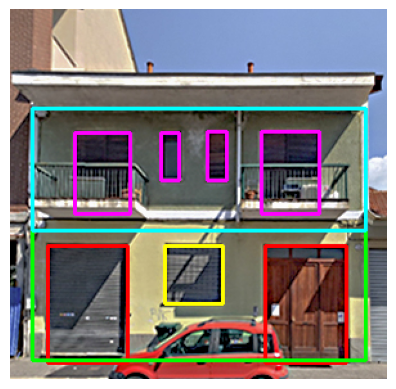

In [13]:
# Visualize one example of stratified detections

strat_img = plot_stratified(check_id, stratified_df, src_img_dir=SAMPLE_IMG_DIR, line_weight=2, show_img=True, save_file=False, save_dir=None)

In [14]:
# Run for loop through all ids in nms_inf_df to stratify detections

stratified_df_lst = []
counter = 0
for img_id in nms_inf_df['image_id'].unique():
  stratified_bldg_df = stratify_df(img_id, nms_inf_df)
  stratified_df_lst.append(stratified_bldg_df)
  counter += 1
  if counter % 100 == 0:
    print(counter)
print('total number of buildings stratified: ', counter)
stratified_df = pd.concat(stratified_df_lst, ignore_index=True)
stratified_df

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
total number of buildings stratified:  1743


,index,image_id,category_id,image_width,image_height,score,x_min_norm,y_min_norm,x_max_norm,y_max_norm,x_min,y_min,x_max,y_max,dataset,area,classification
0,5,863796903_4_left,1,867,594,0.501666,0.195360,0.516757,0.253267,0.613489,169.376687,306.953747,219.582055,364.412377,val,2884.731711,lower_windows
1,4,863796903_4_left,1,867,594,0.880096,0.893276,0.515027,0.943516,0.602003,774.470119,305.926276,818.028545,357.589544,val,2250.370712,lower_windows
2,0,863796903_4_left,1,867,594,0.435650,0.002902,0.156994,0.106502,0.294044,2.516381,93.254436,92.337581,174.662136,val,7312.137303,upper_windows
3,3,863796903_4_left,1,867,594,0.897758,0.894700,0.161575,0.943454,0.298124,775.705030,95.975253,817.974488,177.085359,val,3428.480211,upper_windows
4,4,863796903_4_left,1,867,594,0.902896,0.149779,0.153991,0.260680,0.293610,129.858826,91.470357,226.009994,174.404043,val,7974.170693,upper_windows
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34079,2,864047705_6,1,373,401,0.883129,0.630071,0.156632,0.690499,0.248212,235.016446,62.809252,257.556164,99.533192,inf_ds,827.747294,upper_windows
34080,4,864047705_6,1,373,401,0.903789,0.181230,0.159476,0.247664,0.249496,67.598902,63.949736,92.378560,100.048036,inf_ds,894.503553,upper_windows
34081,5,864047705_6,1,373,401,0.908084,0.433916,0.107258,0.504026,0.212020,161.850761,43.010258,188.001605,85.020220,inf_ds,1098.595968,upper_windows
34082,32461,864047705_6,0,373,401,1.000000,0.087612,0.305689,0.951024,0.604167,32.679462,122.581259,354.731765,242.271167,inf_ds,38546.410702,lower_wall


In [15]:
# Group stratified detections by 'image_id'

grouped_stratified_df = group_stratified_dataframe(stratified_df)
first_col = grouped_stratified_df.pop('osm_id_final')
grouped_stratified_df.insert(0, 'osm_id_final', first_col)
grouped_stratified_df

,osm_id_final,lower_window_area,upper_window_area,lower_wall_area,upper_wall_area,garage_area,lower_wall_area_NET,total_window_area,total_wall_area,WWR_lower,WWR_upper,WWR_total
0,1000108843_2,3522.591255,11166.895194,23519.587158,59928.245544,0.0,23519.587158,14689.486448,83447.832702,0.149773,0.186338,0.176032
1,1000108861_4,3283.618088,68498.577063,29723.348465,210968.317392,0.0,29723.348465,71782.195150,240691.665857,0.110473,0.324687,0.298233
2,1000122222_2,6975.604874,54223.898540,31268.442640,304217.424117,0.0,31268.442640,61199.503414,335485.866757,0.223088,0.178241,0.182421
3,1000122223_2,9076.671941,80940.329612,36729.837287,271931.126526,0.0,36729.837287,90017.001554,308660.963813,0.247120,0.297650,0.291637
4,1000122224_2,4700.530478,15142.729676,55046.066986,145900.828750,0.0,55046.066986,19843.260154,200946.895735,0.085393,0.103788,0.098749
...,...,...,...,...,...,...,...,...,...,...,...,...
1626,999963320_4,5724.402110,30112.720251,51920.080245,322254.297991,0.0,51920.080245,35837.122360,374174.378237,0.110254,0.093444,0.095777
1627,999963321_4,26094.520291,133253.201628,106783.547923,593059.077646,0.0,106783.547923,159347.721919,699842.625569,0.244368,0.224688,0.227691
1628,999963322_2,25411.339678,93822.539668,50423.156802,418818.330616,0.0,50423.156802,119233.879345,469241.487418,0.503962,0.224017,0.254099
1629,999963323_3,16794.114811,65524.186258,34596.729472,284772.153231,0.0,34596.729472,82318.301069,319368.882703,0.485425,0.230093,0.257753


In [ ]:
# Export grouped_stratified_df, as it will be used in the classification algorithm.

fpath = # ADD FILE PATH HERE, e.g. './Project_Name/stratified_detections_by_image_id.xlsx'
grouped_stratified_df.to_excel(fpath, index=False)